In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from pulp import *

%matplotlib inline

In [16]:
t = pd.read_csv('../csv/stochastic_matrix.csv', index_col=0).fillna(0)

In [17]:
v = t.T[[
    'R00200', 'R00268', 'R00341', 'R00342', 'R00351',
    'R00405', 'R00658', 'R00703', 'R01015', 'R01049',
    'R01056', 'R01061', 'R01070', 'R01082', 'R01196', 
    'R01197', 'R01325', 'R01512', 'R01518', 'R01528',
    'R01529', 'R01641', 'R01786', 'R01830', 'R01899',
    'R01900', 'R02035', 'R02164', 'R02740', 'R04779'
]].T

for i in v.columns:
    if sum(v[i] == 0) == v.shape[0]:
        v = v.drop(i, axis=1)
        
v['C00007'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00033'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00092'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00014'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00025'] = pd.Series(np.zeros(v.shape[0]), index=v.index)

In [18]:
df = v.T
df['Glucose_input'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glucose_input']['C00267'] = 1

df['Oxygen_input'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Oxygen_input']['C00007'] = 1

df['CO2_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['CO2_output']['C00011'] = -1

df['Lactate_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Lactate_output']['C00186'] = -1

df['Acetate_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Acetate_output']['C00033'] = -1

df['Glutamate_input'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glutamate_input']['C00025'] = 1

df['Ammonia_input'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Ammonia_input']['C00014'] = 1

df['Glu_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glu_Exchange']['C00267'] = -1
df['Glu_Exchange']['C00092'] = 1

df['acetyl_CoA_hydrolase'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['acetyl_CoA_hydrolase']['C00024'] = -1
df['acetyl_CoA_hydrolase']['C00001'] = -1
df['acetyl_CoA_hydrolase']['C00010'] = 1
df['acetyl_CoA_hydrolase']['C00033'] = 1

df['NADP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['NADP_Exchange']['C00005'] = -1
df['NADP_Exchange']['C00003'] = -1
df['NADP_Exchange']['C00006'] = 1
df['NADP_Exchange']['C00004'] = 1

df['ADP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['ADP_Exchange']['C00002'] = -1
df['ADP_Exchange']['C00008'] = 1

df['AMP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['AMP_Exchange']['C00002'] = -1
df['AMP_Exchange']['C00020'] = -1
df['AMP_Exchange']['C00008'] = 2

df['R00835'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['R00835']['C00092'] = -1
df['R00835']['C00006'] = -1
df['R00835']['C01236'] = 1
df['R00835']['C00005'] = 1
df['R00835']['C00080'] = 1

df['R08575'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['R08575']['C05382'] = -1
df['R08575']['C00118'] = -1
df['R08575']['C00279'] = 1
df['R08575']['C00085'] = 1

df['R02164']['C00004'] = -1
df['R02164']['C00003'] = 1
df['R02164']['C15602'] = 0
df['R02164']['C15603'] = 0

df['R00243'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['R00243']['C00025'] = -1
df['R00243']['C00003'] = -1
df['R00243']['C00001'] = -1

df['R00243']['C00026'] = 1
df['R00243']['C00014'] = 1
df['R00243']['C00004'] = 1
df['R00243']['C00080'] = 1

df['Oxophos'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Oxophos']['C00004'] = -2
df['Oxophos']['C00007'] = -1
df['Oxophos']['C00008'] = -5
df['Oxophos']['C00002'] = 5
df['Oxophos']['C00003'] = 2
df['Oxophos']['C00011'] = 1

In [19]:
BIOMASS = pd.read_csv('../csv/amino_acid.csv',index_col=0)
df_Biomass =  pd.Series(np.zeros(df.shape[0]), index=df.index)

for i in BIOMASS.index:
    df_Biomass[BIOMASS.T[i]['C_num']] = BIOMASS.T[i]['flux']
    
df_Biomass['C00668'] = -0.27519
df_Biomass['C00119'] = (-0.039036) + (-0.036117) + (-0.053446)

In [20]:
df_new = pd.concat([df_Biomass.T, df], axis=1)
df_new = df_new.rename(columns={0: 'BIOMASS'})
df_new = df_new.drop([
    'C00001','C00009','C00080','C00138','C00139','C15602','C15603', 
#     'C00231'
])

In [29]:
rate = pd.DataFrame()
for l in range(0, 400, 1):
    x = []
    for i in df_new.columns:
        if (
                (i=='Oxophos') or (i=='R01899') or (i=='R00268') or (i=='R10343') or (i=='R02164') or (i=='R00835') or 
                (i=='R02035') or (i=='ATP_Exchange') or (i=='AMP_Exchange') or (i=='CO2_output')
        ):
            x.append(LpVariable(i, lowBound=0,upBound=10000, cat='Continuous'))

        elif (i=='Lactate_output'):
            x.append(LpVariable(i, lowBound=0, upBound=10000, cat='Continuous'))
            
        elif (i=='BIOMASS'):
            x.append(LpVariable(i, lowBound=0, upBound=1000, cat='Continuous'))
        
        elif (i=='Oxygen_input'):
            x.append(LpVariable(i, lowBound=0, upBound=l, cat='Continuous'))
        
        elif (i=='Glucose_input'):
            x.append(LpVariable(i, lowBound=100, upBound=100, cat='Continuous'))

        elif (i=='Glutamate_input'):
            x.append(LpVariable(i, lowBound=0, upBound=10000, cat='Continuous'))
            
        elif (i=='Ammonia_input'):
            x.append(LpVariable(i, lowBound=-10000, upBound=10000, cat='Continuous'))
            
        elif (
            (i=='Succinate_output') or (i=='Malate_output') or (i=='Fumarate_output') or (i=='Acetate_output')
        ):
            x.append(LpVariable(i, lowBound=0, upBound=50, cat='Continuous'))
                
        elif (i=='R00200') or (i=='R01196') or (i=='R01197') or (i=='R00405'):
            x.append(LpVariable(i, lowBound=-10000, upBound=0, cat='Continuous'))

        else:
            x.append(LpVariable(i, lowBound=-10000, upBound=10000, cat='Continuous'))

    m = LpProblem(sense=LpMaximize)
    m += x[0]

    for i in np.dot(df_new, x):
        m += i == 0

    status = m.solve()
    print(LpStatus[status])

    y = []
    for i in x:
        y.append(i.value())

    rate = pd.concat([rate,pd.DataFrame(y, index=x).T])

Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal


In [47]:
rate.columns = [str(i) for i in list(rate.columns)]
rate.index = [i/100 for i in range(0, 400)]

In [48]:
rate

,BIOMASS,R00200,R00268,R00341,R00342,R00351,R00405,R00658,R00703,R01015,...,Ammonia_input,Glu_Exchange,acetyl_CoA_hydrolase,NADP_Exchange,ADP_Exchange,AMP_Exchange,R00835,R08575,R00243,Oxophos
0.00,0.000000,-200.000000,0.0,0.000000,0.000000,0.0,0.000000,200.000000,-200.00000,-100.000000,...,0.000000,0.0,0.000000,0.000000,200.00000,0.000000,0.0,0.000000,0.000000,0.0
0.01,0.247829,-199.432720,0.0,-0.156636,0.089035,0.0,0.000000,199.589350,-199.30741,-99.921176,...,-0.278647,0.0,-0.011542,0.776588,198.78561,0.031871,0.0,-0.010624,0.367682,1.0
0.02,0.495658,-198.865440,0.0,-0.313271,0.178070,0.0,0.000000,199.178710,-198.61482,-99.842353,...,-0.557294,0.0,-0.023083,1.553176,197.57123,0.063741,0.0,-0.021247,0.735364,2.0
0.03,0.743488,-198.298160,0.0,-0.469907,0.267105,0.0,0.000000,198.768060,-197.92223,-99.763529,...,-0.835940,0.0,-0.034625,2.329764,196.35684,0.095612,0.0,-0.031871,1.103046,3.0
0.04,0.991317,-197.730880,0.0,-0.626542,0.356141,0.0,0.000000,198.357420,-197.22964,-99.684705,...,-1.114587,0.0,-0.046167,3.106352,195.14246,0.127482,0.0,-0.042494,1.470728,4.0
0.05,1.239146,-197.163590,0.0,-0.783178,0.445176,0.0,0.000000,197.946770,-196.53704,-99.605882,...,-1.393234,0.0,-0.057708,3.882940,193.92807,0.159353,0.0,-0.053118,1.838410,5.0
0.06,1.486975,-196.596310,0.0,-0.939813,0.534211,0.0,0.000000,197.536130,-195.84445,-99.527058,...,-1.671881,0.0,-0.069250,4.659528,192.71369,0.191224,0.0,-0.063741,2.206092,6.0
0.07,1.734805,-196.029030,0.0,-1.096449,0.623246,0.0,0.000000,197.125480,-195.15186,-99.448234,...,-1.950528,0.0,-0.080792,5.436116,191.49930,0.223094,0.0,-0.074365,2.573774,7.0
0.08,1.982634,-195.461750,0.0,-1.253084,0.712281,0.0,0.000000,196.714840,-194.45927,-99.369411,...,-2.229174,0.0,-0.092333,6.212704,190.28492,0.254965,0.0,-0.084988,2.941455,8.0
0.09,2.230463,-194.894470,0.0,-1.409720,0.801316,0.0,0.000000,196.304190,-193.76668,-99.290587,...,-2.507821,0.0,-0.103875,6.989292,189.07053,0.286835,0.0,-0.095612,3.309137,9.0


Text(0.5,0,'Glucose-Oxygen rate (Oxygen/Glc)')

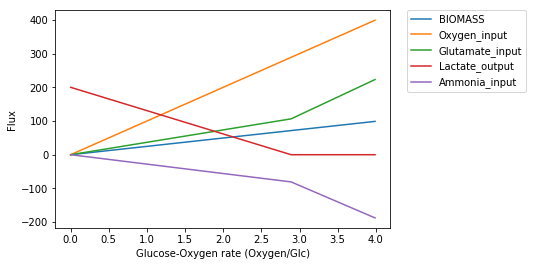

In [53]:
rate[[
    'BIOMASS', 'Oxygen_input', 'Glutamate_input', 'Lactate_output', 'Ammonia_input'
]].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.ylabel('Flux')
plt.xlabel('Glucose-Oxygen rate (Oxygen/Glc)')

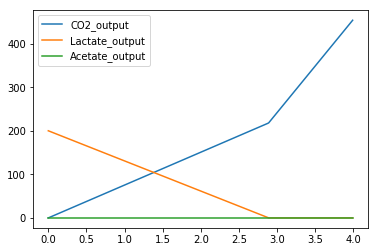

In [49]:
rate[[
    'CO2_output', 'Lactate_output', 
#     'Succinate_output', 
#     'Malate_output', 'Fumarate_output', 
    'Acetate_output', 
#     'Ammonia_output'
]].plot()
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)

In [ ]:
rate['Oxygen_input'].plot()

In [ ]:
rate[[
    'Lactate_output', 'Ammonia_output', 'Glucose_input', 'Glutamate_input'
]]

In [ ]:
rate[['Glucose_input', 'Oxygen_input',
       'CO2_output', 'Lactate_output', 'Acetate_output', 'Glutamate_input',
       'Ammonia_output', 'Glu_Exchange']]

In [ ]:
norm_result = pd.concat([
    pd.DataFrame(rate[ 'Glutamate_input']/rate['Glutamate_input']),
    pd.DataFrame(rate[ 'Lactate_output']/rate['Glutamate_input']),
    pd.DataFrame(rate[ 'Glucose_input']/rate['Glutamate_input']), 
    pd.DataFrame(rate[ 'Ammonia_output']/rate['Glutamate_input'])],
    axis=1
)
#     'Glucose_input', 'Lactate_output', 'Glutamate_input', 'Ammonia_output'
norm_result.columns = ['Glucose', 'Lac', 'Glutamate', 'Ammonia']
norm_result.plot()

In [ ]:
# norm_result.to_csv('../result/grad_glc.csv')